# ML(CNN) 모델 적용을 위한 데이터셋 생성하기

## 1. 데이터 불러오기

'[1_훼손 영역에 대한 검출 가능성.ipynb](./1_%ED%9B%BC%EC%86%90%20%EC%98%81%EC%97%AD%EC%97%90%20%EB%8C%80%ED%95%9C%20%EA%B2%80%EC%B6%9C%20%EA%B0%80%EB%8A%A5%EC%84%B1.ipynb)'에서 생성한 데이터를 사용.

In [1]:
import numpy as np
import cv2

import os
import math

from src import dataset

In [2]:
# 위 코드에 이어서...

DATA_PATH = "data/tmp"
DATA_LIST_PATH = os.path.join(DATA_PATH, f".datalist")

# --------------------------------

# 1. 불러와야 할 데이터들의 파일명 수집
if not os.path.exists(DATA_PATH): raise Exception("No data.")

file_basename_list = []

with open(DATA_LIST_PATH, "r") as f:
    file_basename_list = f.readlines()
    file_basename_list = [file_basename.rstrip() for file_basename in file_basename_list]

# --------------------------------

# 2. 데이터를 불러오는 함수
def load(file_basename_list=file_basename_list):
    for file_basename in file_basename_list:
        file_basename = os.path.join(DATA_PATH, file_basename)

        file_name, file_extension = os.path.splitext(file_basename)
        
        raw          = cv2.imread(f"{file_basename}",                          cv2.IMREAD_COLOR)
        mask         = cv2.imread(f"{file_name}_mask{file_extension}",         cv2.IMREAD_GRAYSCALE)
        mask_colored = cv2.imread(f"{file_name}_mask-colored{file_extension}", cv2.IMREAD_COLOR)

        if raw is None:
            raise Exception(f"Imread failed: {file_basename} from {file_basename_list}")

        yield file_basename, raw, mask, mask_colored
    
# --------------------------------

data_list = list(load())

## 2. OpenCV의 UI를 이용하여 데이터셋 생성

In [3]:
# 위 코드에 이어서...

mx, my = 0, 0
win_name = 'create dataset'
data_info = {
    'basename': '',
    'frame' : {
        'raw': None,
        'mask': None,
        'mask-colored': None
    }
}

# --------------------------------

def onMouse(event, x, y, flags, param):
    """마우스 포인터의 좌표 갱신"""
    global mx, my
    if event == cv2.EVENT_MOUSEMOVE:
        mx, my = x, y

def updateDataset(basename, raw, mask, mask_colored):
    global data_info
    data_info['basename'] = basename
    data_info['frame']['raw'] = raw
    data_info['frame']['mask'] = mask
    data_info['frame']['mask-colored'] = mask_colored

def makePoints(n, cx, cy, min_point, max_point):
    """중심의 좌표(cx,cy)와 한 변의 길이(n)을 이용하여
    정사각형의 두 꼭짓점의 좌표를 계산."""
    x0, y0 = math.floor(cx - n/2), math.floor(cy - n/2)
    x1, y1 = math.floor(cx + n/2), math.floor(cy + n/2)

    # 범위 밖 좌표를 방지하기 위한 보정
    dx, dy = 0, 0
    padding = 4

    minx, miny = min_point
    maxx, maxy = max_point
    
    if (x0 < minx): dx = minx -x0 + padding
    if (x1 > maxx): dx = maxx -x1 - padding

    if (y0 < miny): dy = miny -y0 + padding
    if (y1 > maxy): dy = maxy -y1 - padding

    if (x1-x0) == (y1-y0) != n:
        raise Exception('width height does not match?')

    if dx == dy == 0:
        return x0, y0, x1, y1
    else:
        return makePoints(n, cx+dx, cy+dy, min_point, max_point)

# --------------------------------

cv2.namedWindow(win_name)
cv2.setMouseCallback(win_name, onMouse)

updateDataset(*data_list[0])

# --------------------------------

frame = None

while True:
    frame_info = data_info['frame']

    h, w = frame_info['raw'].shape[:2]
    x0,y0,x1,y1 = makePoints(28, mx, my, (0,0), (w,h))

    frame = cv2.addWeighted(
        frame_info['raw'],          0.75,
        frame_info['mask-colored'], 0.75, 0)

    cv2.rectangle(frame, (x0,y0), (x1,y1), (0,0,255), 1)
    cv2.imshow(win_name, frame)

    key = chr(cv2.waitKey(10) & 0xFF)
    if key == 'q':
        break
    if key in "0123456789":
        x_save = [ frame_info['raw'][y0:y1, x0:x1] ]
        y_save = [ key ]
        dataset.save(x_save, y_save)

cv2.imshow(win_name, frame)
cv2.destroyWindow(win_name)

<function matplotlib.pyplot.show(*args, **kw)>

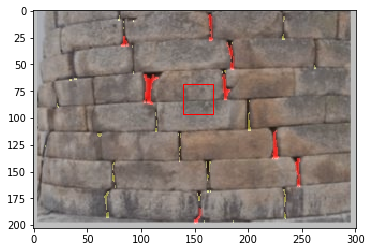

In [4]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show